In [77]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss




In [78]:
# Set the start and end date for data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'

# Download stock data
stock = yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


              Open    High     Low   Close  Adj Close     Volume  Log Price  \
Date                                                                          
2023-01-03  14.851  14.996  14.096  14.315  14.305582  401277000   2.660650   
2023-01-04  14.567  14.853  14.241  14.749  14.739295  431324000   2.690517   
2023-01-05  14.491  14.564  14.148  14.265  14.255612  389168000   2.657151   
2023-01-06  14.474  15.010  14.034  14.859  14.849224  405044000   2.697948   
2023-01-09  15.284  16.056  15.141  15.628  15.617717  504231000   2.748406   

            Log Returns  
Date                     
2023-01-03          NaN  
2023-01-04     0.029867  
2023-01-05    -0.033366  
2023-01-06     0.040797  
2023-01-09     0.050458  


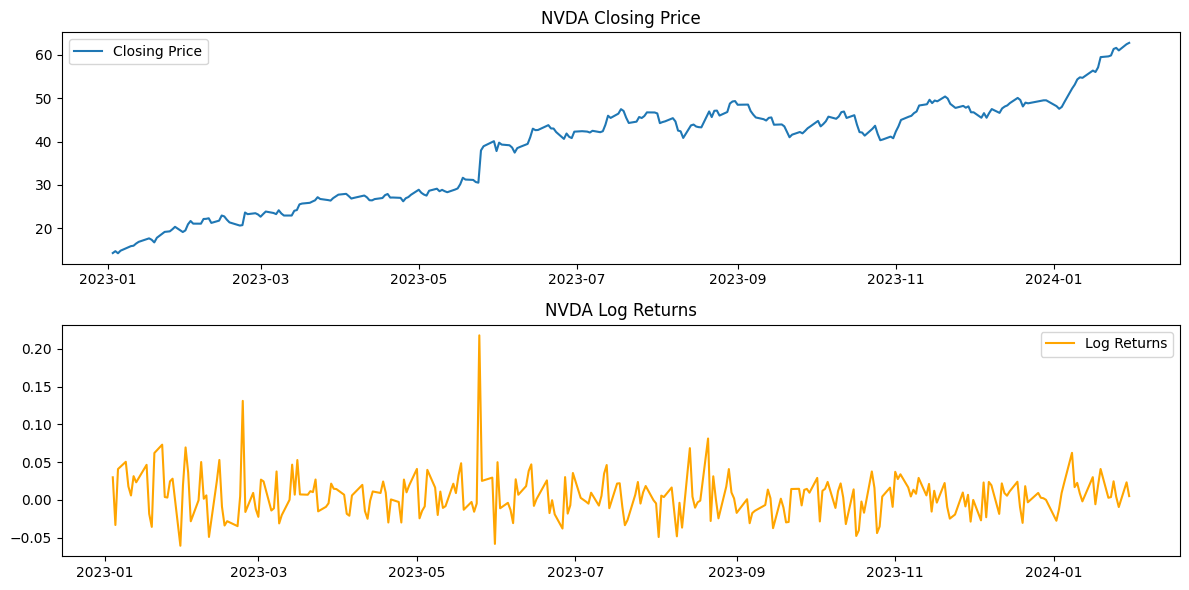

In [79]:
# Apply log transformation to the adjusted close price
stock['Log Price'] = np.log(stock['Adj Close'])

# Calculate log returns as the difference of log prices
stock['Log Returns'] = stock['Log Price'].diff()

# Check if 'Log Returns' is created successfully
print(stock.head())  # Display the first few rows to verify

# Extract the log returns as a numpy array and calculate the length
Y = stock['Log Returns'].dropna().values  # Drop any NaN values before use
T = len(Y)  # Length of time series after dropping NaN values

# Plot the closing prices and log returns for visual inspection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock['Adj Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stock['Log Returns'], label='Log Returns', color='orange')
plt.title(f'{stock_symbol} Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
# GARCH likelihood function
def garch(param, *args):
    mu, omega, alpha, beta = param
    sigma2 = {}
    GARCH_Dens = {}
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        F_t = Y[t] - mu - np.sqrt(sigma2[t]) * np.random.normal(0, 1)
        GARCH_Dens[t] = 0.5 * np.log(2 * np.pi) + 0.5 * np.log(sigma2[t]) + 0.5 * (F_t / sigma2[t])
        Likelihood += GARCH_Dens[t]
    return Likelihood

# GARCH path generation function
def garch_path(params, *args):
    mu, omega, alpha, beta = params
    sigma2 = {}
    path = {}
    sigma2[0] = np.var(Y)
    path[0] = Y[0]
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        path[t] = mu + np.sqrt(sigma2[t]) * np.random.normal(0, 1)
    return path, sigma2


In [81]:
# Initial parameter guess
param0 = np.array([np.mean(Y), np.var(Y) / 900, 0.6, 0.15])

# Optimize parameters using maximum likelihood estimation
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x  # Optimized parameters


c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -1334.385200
         Iterations: 1
         Function evaluations: 102
         Gradient evaluations: 18


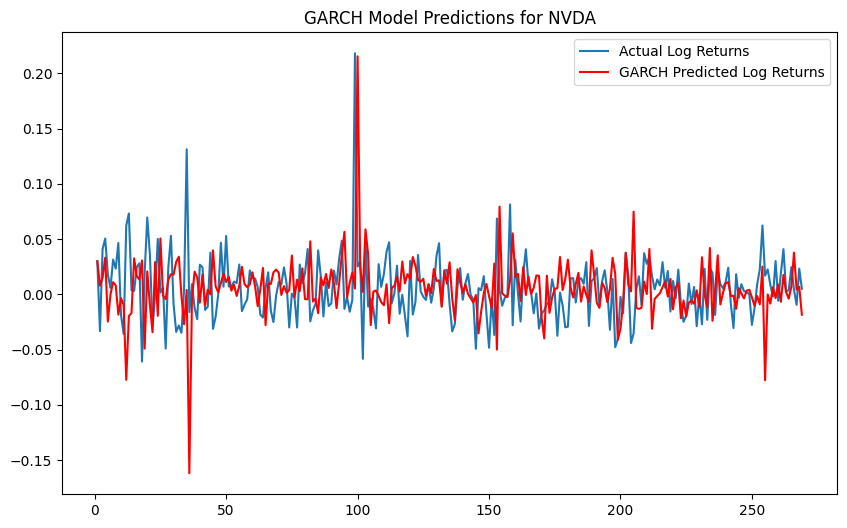

RMSE value is: 0.038818299007330886


In [82]:
# Generate GARCH-predicted path and volatility
path, vol = garch_path(param_star, Y, T)
Y_GARCH = np.array(list(path.values()))
timevec = np.linspace(1, T, T)

# Plot actual log returns vs. GARCH-predicted log returns
plt.figure(figsize=(10, 6))
plt.plot(timevec, Y, label='Actual Log Returns')
plt.plot(timevec, Y_GARCH, label='GARCH Predicted Log Returns', color='red')
plt.title(f'GARCH Model Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Calculate RMSE between actual and GARCH-predicted returns
RMSE = np.sqrt(np.mean((Y_GARCH - Y) ** 2))
print(f'RMSE value is: {RMSE}')
